In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from datetime import timedelta
import missingno as msno

# 온라인 스토어 유저 데이터 분석
## 데이터 설명
- `2020-09-24 ~ 2020-12-21`에 걸쳐 일어난 온라인 스토어 유저 데이터
- 컬럼 설명
    - `event_time` : 이벤트 발생 시간
    - `event_type` : 발생한 이벤트 (view, cart, purchase)
    - `product_id` : 제품 id
    - `category_id` : 제품이 속한 카테고리 id
    - `category_code` : 제품이 속한 카테고리 코드
    - `price` : 가격
    - `user_id` : 로그인한 유저 id
    - `user_session` : 유저가 활동한 세션

In [2]:
file_path = "data/events.csv"
df = pd.read_csv(file_path)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2.140000e+18,electronics.telephone,NaN,31.90,1.520000e+18,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2.140000e+18,computers.components.cooler,zalman,17.16,1.520000e+18,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2.140000e+18,NaN,NaN,9.81,1.520000e+18,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2.140000e+18,computers.peripherals.printer,pantum,113.81,1.520000e+18,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481999 entries, 0 to 481998
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     481999 non-null  object 
 1   event_type     481999 non-null  object 
 2   product_id     481999 non-null  int64  
 3   category_id    481999 non-null  float64
 4   category_code  343374 non-null  object 
 5   brand          362130 non-null  object 
 6   price          481999 non-null  float64
 7   user_id        481999 non-null  float64
 8   user_session   481867 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# 결측치 확인
df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    138625
brand            119869
price                 0
user_id               0
user_session        132
dtype: int64

In [5]:
df_copy = df.copy()

### event_time 컬럼 나누기

In [6]:
# event_time 컬럼 str -> datetime64로 변경
df_copy["event_time"] = pd.to_datetime(df_copy["event_time"])

# event_time 컬럼 월, 일, 요일, 시로 분리
df_copy["month"] = df_copy["event_time"].dt.month
df_copy["day"] = df_copy["event_time"].dt.day
df_copy["day_name"] = df_copy["event_time"].apply(lambda x : x.day_name())
df_copy["hour"] = df_copy["event_time"].dt.hour

col_order = ['event_time', 'month', 'day', 'day_name', 'hour', 
             'event_type', 'product_id', 'category_id', 'category_code', 
             'brand', 'price', 'user_id', 'user_session']
df_copy = df_copy[col_order]
df_copy.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,NaN,31.90,1.520000e+18,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,9,24,Thursday,11,view,139905,2.140000e+18,computers.components.cooler,zalman,17.16,1.520000e+18,tdicluNnRY
2,2020-09-24 11:57:27+00:00,9,24,Thursday,11,view,215454,2.140000e+18,NaN,NaN,9.81,1.520000e+18,4TMArHtXQy
3,2020-09-24 11:57:33+00:00,9,24,Thursday,11,view,635807,2.140000e+18,computers.peripherals.printer,pantum,113.81,1.520000e+18,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,9,24,Thursday,11,view,3658723,2.140000e+18,NaN,cameronsino,15.87,1.520000e+18,aa4mmk0kwQ


In [7]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481999 entries, 0 to 481998
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     481999 non-null  datetime64[ns, UTC]
 1   month          481999 non-null  int32              
 2   day            481999 non-null  int32              
 3   day_name       481999 non-null  object             
 4   hour           481999 non-null  int32              
 5   event_type     481999 non-null  object             
 6   product_id     481999 non-null  int64              
 7   category_id    481999 non-null  float64            
 8   category_code  343374 non-null  object             
 9   brand          362130 non-null  object             
 10  price          481999 non-null  float64            
 11  user_id        481999 non-null  float64            
 12  user_session   481867 non-null  object             
dtypes: datetime64[ns, UTC](1), fl

In [8]:
df_copy["event_type"].value_counts()

event_type
view        435940
cart         26812
purchase     19247
Name: count, dtype: int64

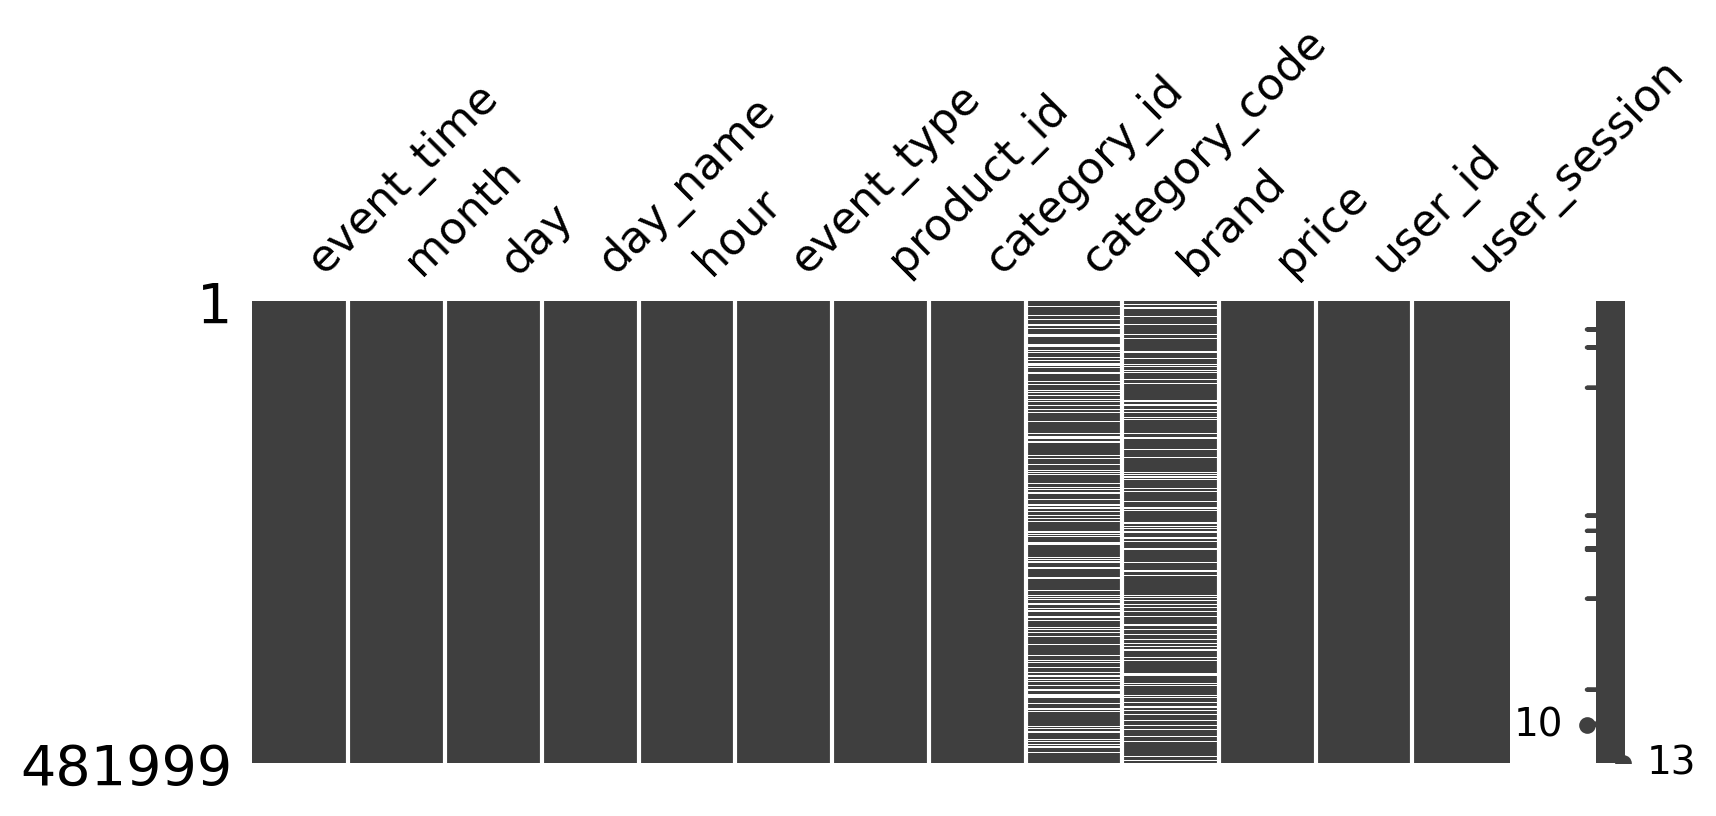

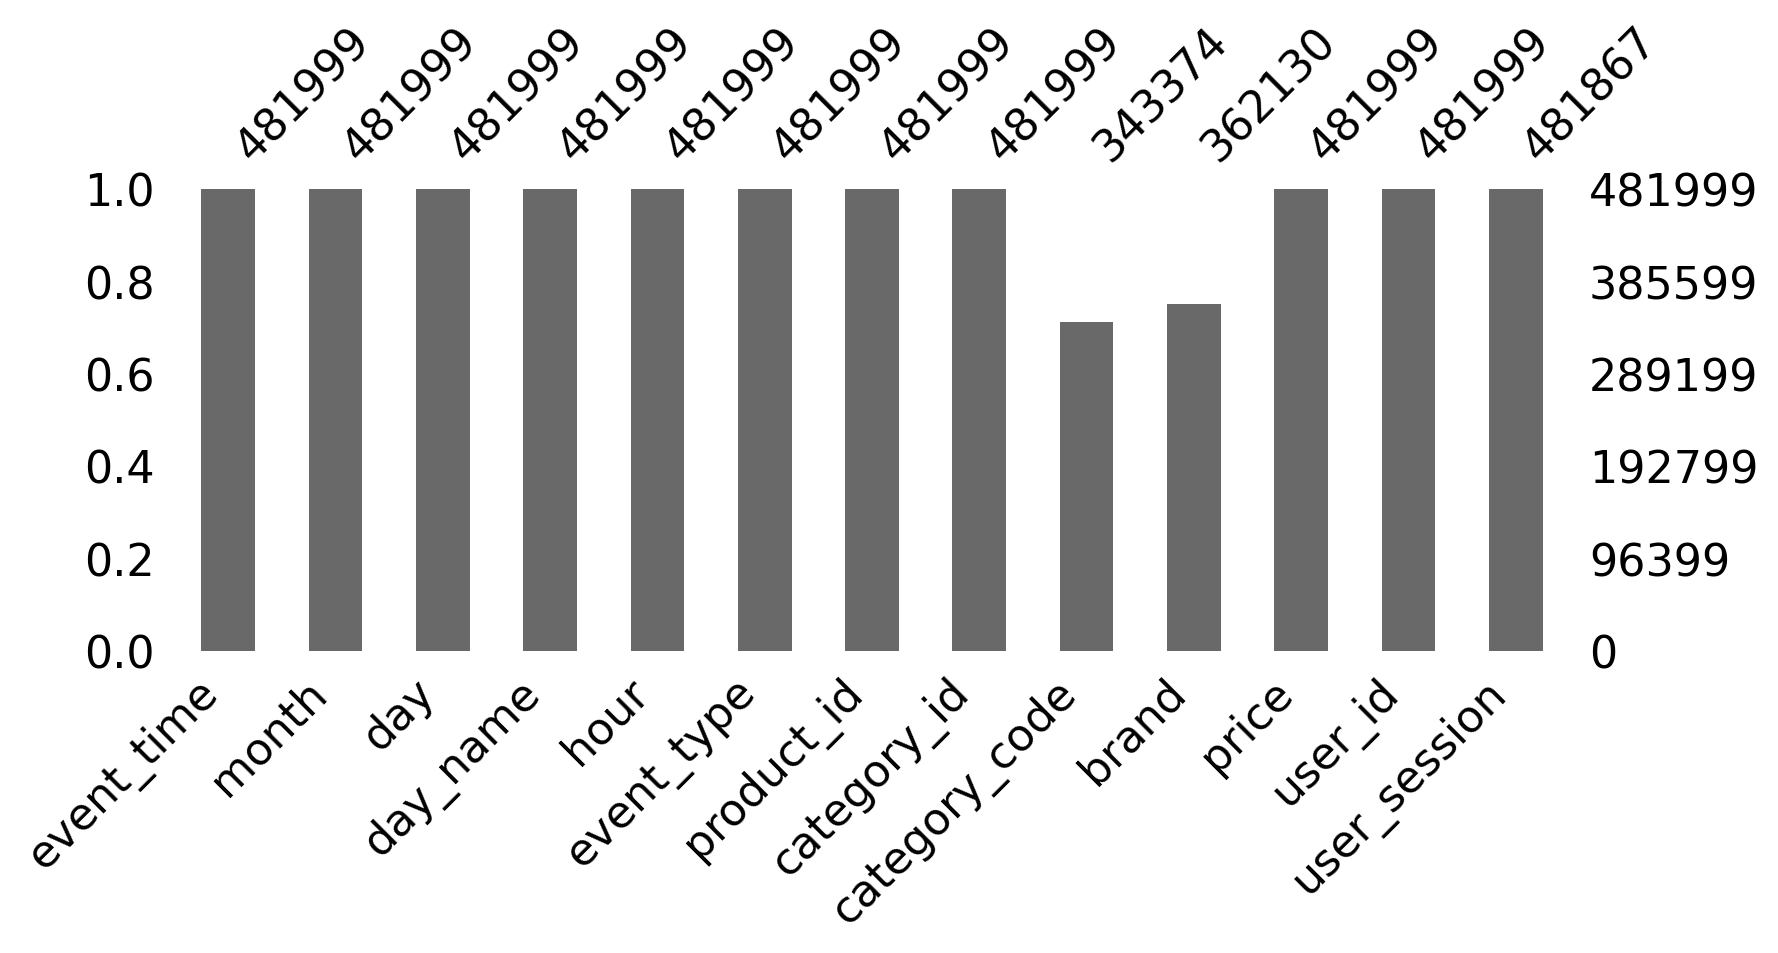

In [19]:
# 결측치 시각화
msno.matrix(df=df_copy, figsize=(9,3))
plt.show()

msno.bar(df_copy, figsize=(9,3))
plt.show()

In [40]:
# 결측치 비율 구함
null_total = df_copy.isnull().sum()
null_count = df_copy.isnull().count()
null_pct = round((null_total/null_count)*100, 1)

# 결측치 개수, 퍼센트 데이터프레임으로 생성
missing = pd.concat([null_total, null_pct], axis=1, keys=["Total", "Percent"])
missing


,Total,Percent
event_time,0,0.0
month,0,0.0
day,0,0.0
day_name,0,0.0
hour,0,0.0
event_type,0,0.0
product_id,0,0.0
category_id,0,0.0
category_code,138625,28.8
brand,119869,24.9


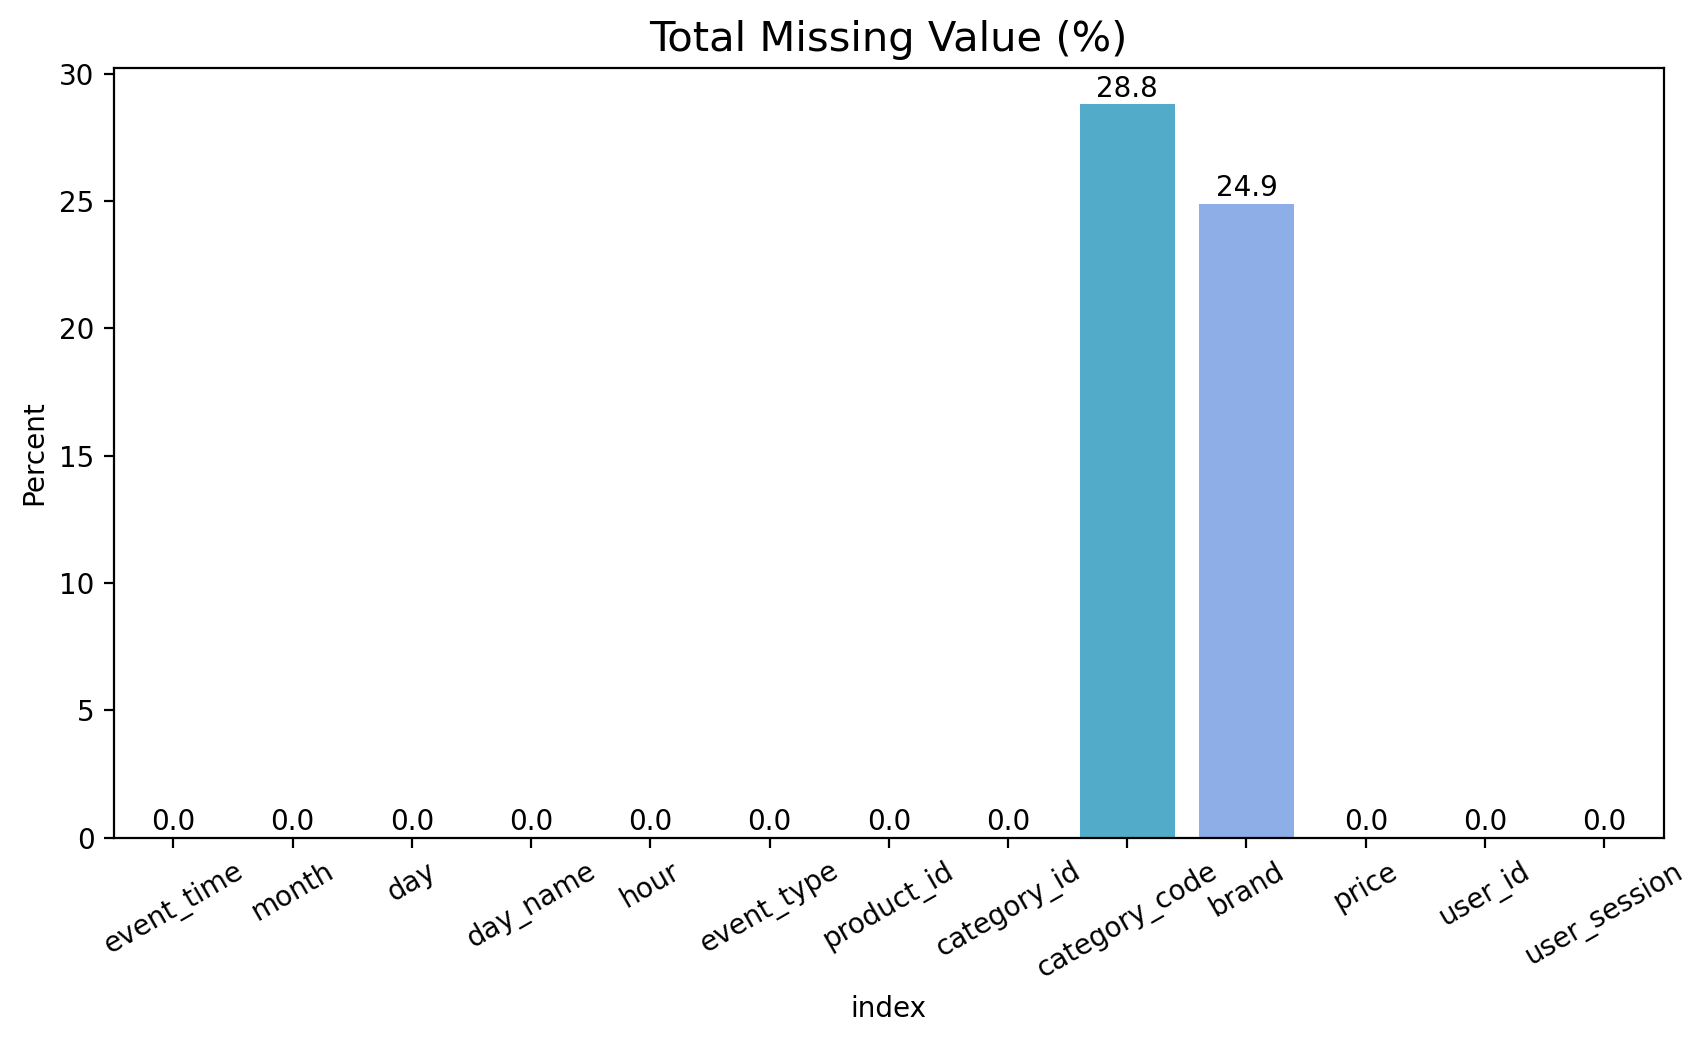

In [66]:
# 결측치 비율 시각화
plt.figure(figsize=(10, 5))
sns_pct = sns.barplot(x="index", y="Percent", data=missing.reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.3,                        # 퍼센트 글자 높이
             "%.1f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

In [ ]:
# https://cheris8.github.io/data%20analysis/DP-NA-Imputation/